## Ethereum Blockchain Transaction Analysis

### Link to GitHub Repository
https://github.com/cs418-fa24/project-check-in-team-2

## Project Introduction
In this project, we are analyzing Ethereum blockchain transaction data to investigate trends and insights related to recent transactions.
Our primary focus is to explore transaction patterns, fees, and the frequency of various transaction types to gain a deeper understanding of blockchain dynamics.

This analysis involves collecting recent transactions, cleaning the data, performing exploratory data analysis (EDA), and applying machine learning techniques to gain insights.

### Key Questions:
1. What patterns or trends can be identified in Ethereum transactions?
2. Are there specific metrics that can help predict Ethereum price movements?

## Changes to Project Scope
Since the initial proposal, we have made the following changes:
- **Scope Addition**: We have included a deeper analysis of transaction fees and patterns by block height to identify temporal patterns.
- **Scope Reduction**: We initially planned to analyze more historical data; however, we have limited the scope to recent blocks due to time constraints.

These adjustments will allow us to focus on recent trends and complete the analysis within the project timeline.

## Data Collection (Etherscan)
**Data Source:** The data is collected from [Etherscan.io](https://etherscan.io/txs) using Selenium, focusing on transaction hashes, block numbers, timestamps, addresses, and fees.

**Initial Observations:** The collected data includes transactional attributes that enable an analysis of transaction patterns, including frequency, transaction values, and fees.


Using Selenium, we automate the collection of transaction data, specifically gathering transaction hashes, block numbers, timestamps, addresses, and fees.

In [2]:
%pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [3]:
from bs4 import BeautifulSoup as bs
import requests as req
from selenium.webdriver.common.action_chains import ActionChains
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import math
import time
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import numpy as np
from math import sqrt
import random

We have disabled the data collection process by commenting it out, as the data has already been saved in a CSV file.

In [4]:
# # Initialize WebDriver
# driver = webdriver.Chrome()

In [5]:
# # Navigate to the blocks page to retrieve the latest block ID
# driver.get("https://etherscan.io/blocks")
# time.sleep(1)
# lastBlock = driver.find_element(by=By.XPATH, value="//*[@id=\"content\"]/section[2]/div[2]/div[2]/table/tbody/tr[1]/td[1]/a")
# lastBlockID = int(lastBlock.text)

In [6]:
# # Generate URLs for the last 20 blocks
# blockURLs = []
# for blockID in range(lastBlockID, lastBlockID-20, -1):
#     blockURLs.append("https://etherscan.io/txs?block=" + str(blockID))

In [7]:
# # Function to read each row's data in the transactions table
# def readRow(rowIndex):
#     row = {}
#     xPath = "//*[@id=\"ContentPlaceHolder1_divTransactions\"]/div[2]/table/tbody/tr[" + str(rowIndex) + "]/"
#     row["txnHash"] = driver.find_element(by=By.XPATH, value=xPath + "td[2]/div/span/a").text
#     row["method"] = driver.find_element(by=By.XPATH, value=xPath + "td[3]/span").text
#     row["block"] = driver.find_element(by=By.XPATH, value=xPath + "td[4]/a").text
#     row["age"] = driver.find_element(by=By.XPATH, value=xPath + "td[6]/span").text
#     row["from"] = driver.find_element(by=By.XPATH, value=xPath + "td[8]/div/a[1]").get_attribute("href").split("/")[-1]
#     row["to"] = driver.find_element(by=By.XPATH, value=xPath + "td[10]/div").find_elements(by=By.CSS_SELECTOR, value="a")[-1].get_attribute("data-clipboard-text")
#     row["value"] = driver.find_element(by=By.XPATH, value=xPath + "td[11]/span").text
#     row["txnFee"] = driver.find_element(by=By.XPATH, value=xPath + "td[12]").text
#     return row

*We used time.sleep(1) to avoid being blocked by the website.*

In [8]:
# # Collect data for each block
# table = []
# for blockUrl in tqdm(blockURLs, desc="Collecting Data Blocks ("):
#     driver.get(blockUrl)
#     tranCount = int(driver.find_element(by=By.XPATH, value="//*[@id=\"ContentPlaceHolder1_divDataInfo\"]/div/div[1]/span").text.split(" ")[3])
#     pageCount = math.ceil(tranCount / 50)
#     for pageIndex in range(1, pageCount + 1):
#         url = blockUrl + "&p=" + str(pageIndex)
#         driver.get(url)
#         time.sleep(1)
#         rowBound = (tranCount - (pageCount - 1) * 50 + 1) if (pageIndex == pageCount) else 51
#         for rowIndex in range(1, rowBound):
#             table.append(readRow(rowIndex))
#     time.sleep(1)

*We're creating a CSV file to use later, so we don't have to run this code again.*

In [9]:
# Convert to DataFrame and save to CSV
# dataFrame = pd.DataFrame(table)
# dataFrame.to_csv("DataFrame.csv", index=False)

# # Close the driver
# driver.quit()

## Data Cleaning
For this halfway report, we have completed the initial data cleaning steps:

**Incomplete Records Removal:** Rows with missing or incomplete data are removed to ensure a consistent dataset.

**Standardizing Columns:** Timestamps are standardized, and columns that are not useful for analysis (e.g., transaction hash, method, age, from, to) are dropped to streamline the dataset.

**Outliers Removal:** Outliers are identified and removed based on values outside 3 standard deviations from the mean, assuming a normal distribution.


*Removing columns that we do not need to analyze from the DataFrame.*

In [10]:
cleanedDataFrame = pd.read_csv("DataFrame.csv")
cleanedDataFrame = cleanedDataFrame.drop(["txnHash", "method", "age", "from", "to"], axis=1)

*We are changing the data type of the 'Value' and 'txnFee' columns to float.*

In [11]:
cleanedDataFrame["txnFee"] = cleanedDataFrame["txnFee"].apply(lambda x: float(x))
pattern = r"(\d+\.?\d*)"
cleanedDataFrame["value"] = cleanedDataFrame["value"].apply(lambda x: float(re.findall(pattern, x)[0]))

*We are removing outliers by identifying and excluding data points that fall outside the range of 3 standard deviations from the mean, based on the assumption that the dataset follows a normal distribution.*

In [12]:
threshold = 3
columnsForProcess = ['value', 'txnFee']
outliersMask = ~((cleanedDataFrame[columnsForProcess] - cleanedDataFrame[columnsForProcess].mean()).abs() > threshold * cleanedDataFrame[columnsForProcess].std()).any(axis=1)
cleanedDataFrameWithoutOutlier = cleanedDataFrame[outliersMask]

 **Basic Statistics**

- **Mean and Standard Deviation:** The mean and standard deviation for 'value' and 'txnFee' columns give insight into the central tendency and variability of transaction values and fees after outlier removal.
- **Histogram Binning Strategy:** Using the square root of the data size as the bin count is a good approach for balancing visual interpretability and detail without overfitting to outliers.

In [13]:
valueMean = cleanedDataFrameWithoutOutlier['value'].mean()
valueStd = cleanedDataFrameWithoutOutlier['value'].std()
feeMean = cleanedDataFrameWithoutOutlier['txnFee'].mean()
feeStd = cleanedDataFrameWithoutOutlier['txnFee'].std()
print("Value Column:")
print("Mean:", valueMean)
print("Standard Deviation:", valueStd)
print("\ntxnFee Column:")
print("Mean:", feeMean)
print("Standard Deviation:", feeStd)

Value Column:
Mean: 0.2901379006318644
Standard Deviation: 2.4571333143219043

txnFee Column:
Mean: 0.0007800431423728814
Standard Deviation: 0.0011140786725361243


## Data Visualization & Distribution Analysis

We are using the method of setting the bin size to the square root of the dataset size to achieve a balanced number of optimally sized bins that provide a robust and visually interpretable representation of the data distribution, while mitigating the impact of outliers.

Histograms of Value and Transaction Fees:

- The histogram for transaction values allows an assessment of the spread and frequency of different transaction sizes.
- Observing the histogram post-outlier removal and with zero-value transactions filtered out helps highlight significant transaction patterns, showing a skewed distribution of transaction values and fees.



C:\Users\Shreyash\AppData\Local\Temp\ipykernel_14840\3089463078.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cleanedDataFrameWithoutOutlier["value"],bins=binValue)


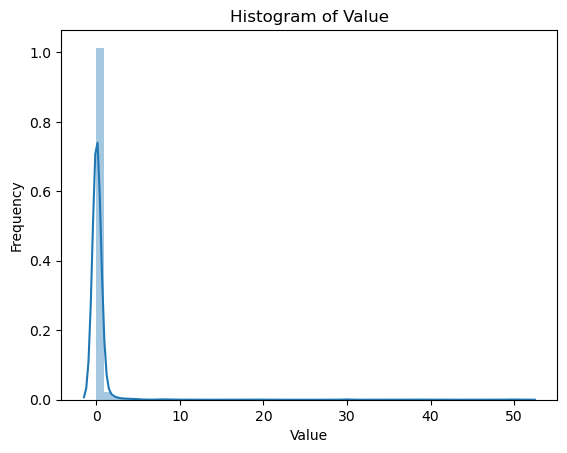

In [14]:
binValue=int(sqrt(len(cleanedDataFrameWithoutOutlier["value"])))
sns.distplot(cleanedDataFrameWithoutOutlier["value"],bins=binValue)
plt.title('Histogram of Value')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [15]:
removedZeroesDF = cleanedDataFrameWithoutOutlier["value"]
removedZeroesDF = removedZeroesDF[removedZeroesDF != 0]
removedZeroesDF = removedZeroesDF.reset_index()

C:\Users\Shreyash\AppData\Local\Temp\ipykernel_14840\2352884895.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(removedZeroesDF["value"],bins=binValue)


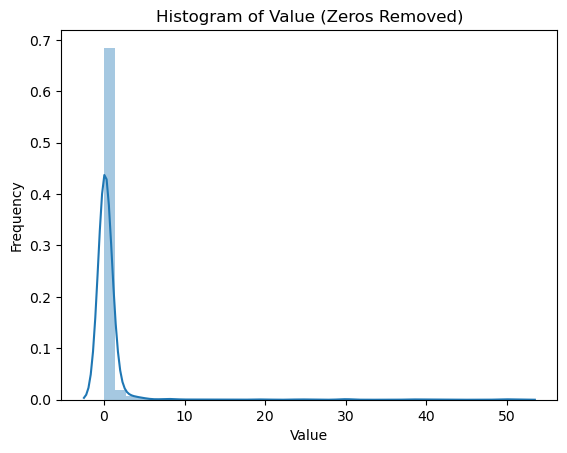

In [16]:
binValue=int(sqrt(len(removedZeroesDF["value"])))
sns.distplot(removedZeroesDF["value"],bins=binValue)
plt.title('Histogram of Value (Zeros Removed)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

C:\Users\Shreyash\AppData\Local\Temp\ipykernel_14840\816413759.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cleanedDataFrameWithoutOutlier["txnFee"],bins=binValue)


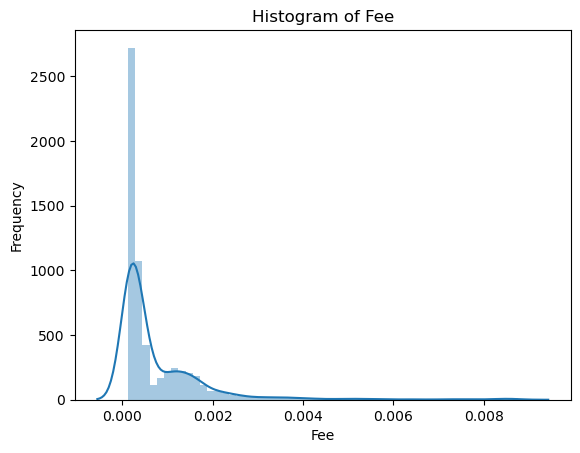

In [17]:
binValue=int(sqrt(len(cleanedDataFrameWithoutOutlier["txnFee"])))
sns.distplot(cleanedDataFrameWithoutOutlier["txnFee"],bins=binValue)
plt.title('Histogram of Fee')
plt.xlabel('Fee')
plt.ylabel('Frequency')
plt.show()

**Violin and Box Plots for Transaction Value and Fees:**

**Violin Plot:** Provides a detailed view of the distribution and density of transaction values and fees. It helps in identifying whether the data follows a normal distribution or has skewness, and shows where data clusters.

**Box Plot:** Highlights central values, variability, and outliers within the range of transaction values and fees. It visually emphasizes extreme values and spread for further analysis.

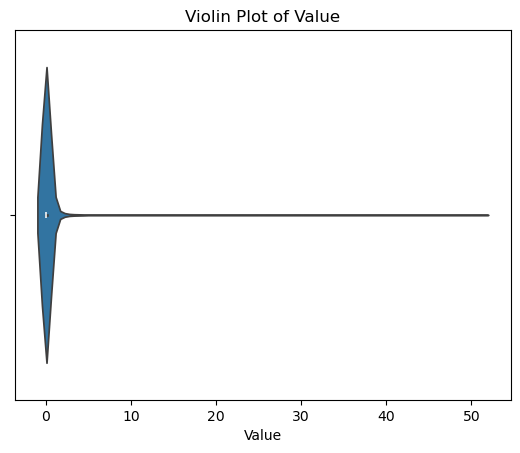

In [18]:
sns.violinplot(x=cleanedDataFrameWithoutOutlier["value"])
plt.xlabel("Value")
plt.title("Violin Plot of Value")
plt.show()

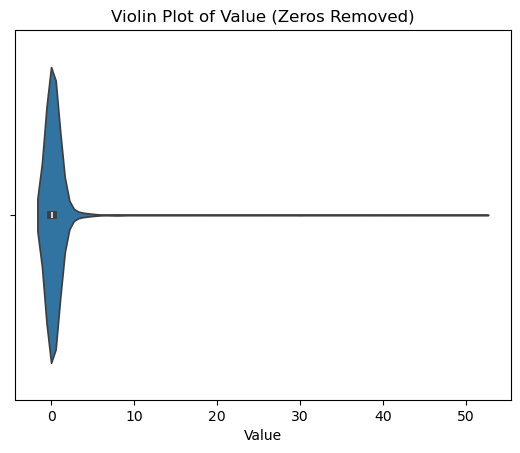

In [19]:
sns.violinplot(x=removedZeroesDF["value"])
plt.xlabel("Value")
plt.title("Violin Plot of Value (Zeros Removed)")
plt.show()

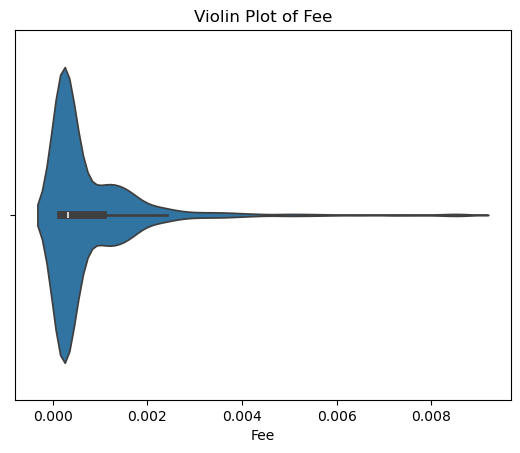

In [20]:
sns.violinplot(x=cleanedDataFrameWithoutOutlier["txnFee"])
plt.xlabel("Fee")
plt.title("Violin Plot of Fee")
plt.show()

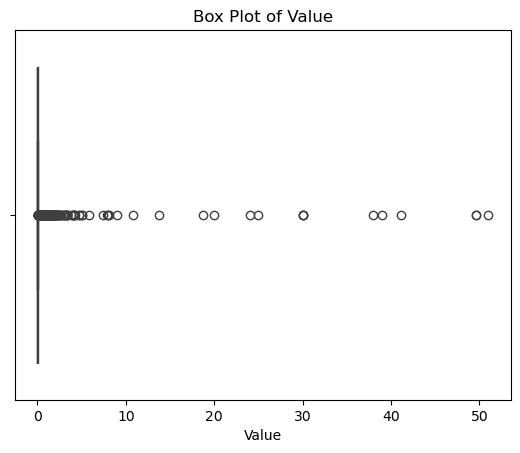

In [21]:
sns.boxplot(x=cleanedDataFrameWithoutOutlier["value"])
plt.xlabel("Value")
plt.title("Box Plot of Value")
plt.show()

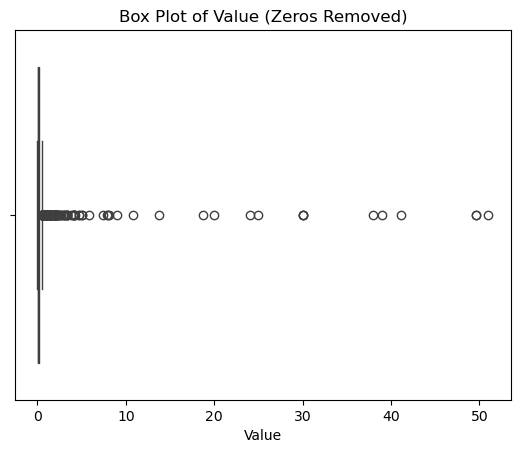

In [22]:
sns.boxplot(x=removedZeroesDF["value"])
plt.xlabel("Value")
plt.title("Box Plot of Value (Zeros Removed)")
plt.show()

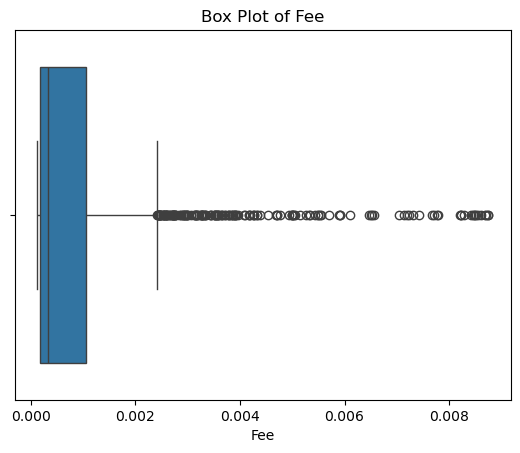

In [23]:
sns.boxplot(x=cleanedDataFrameWithoutOutlier["txnFee"])
plt.xlabel("Fee")
plt.title("Box Plot of Fee")
plt.show()